# Working with Multielectrode Data in pandas

Whereas the data we imported from Matlab are in a somewhat Byzantine embedded format, pandas offers a more simple and intuitive format, often called **long format**, in which data are stored in a 2-dimensional matrix (rows and columns), with one data point per row. Each row comprises the data itself, and additional columns that label the data. 

For this data set, using pandas long format, we'll want columns for:
- channel (which electrode the data came from)
- sort code
- time (of spike)
- orientation
- trial number

One downside of long format is that it is not memory-efficient, since we have so many redundant labels. In contrast, think back to the `ten_intensities` data in previous sections of the chapter. That data was stored as a dictionary, with each entry in the dictionary being the contrast label. Therefore, the contrast label only had to be stored once in memory, and all the data inside the dictionary entry would be categorized as having that label. In contrast, every data point in pandas carries a copy of the intensity label, meaning more information is stored in memory. 

There are two significant downsides of less efficient memory storage. Firstly, that it takes more memory (RAM) on the system it's running on. In large data sets, the amount of RAM available (either on a computer or a cloud server) may actually become a limitation in the amount of data you can work with. Secondly, operations on the data tend to take longer, due to the larger amount of information that needs to be processed. Pandas is written to handle large data pretty efficiently, but it's not always the most efficient way of doing things. 

On the other hand, long data is very intuitive to work with, and avoids having to resort to the complex embedded data structure described above in decoding the Matlab file. And pandas is a great package to work with, as it provides a lot of powerful features for manipulating data, and grouping it by different properties and combinations of properties. These are tasks we routinely want to do in neural data science, and it becomes easier to work with different data sets and even types of data, if we consistently use a common framework like pandas. And in spite of its somewhat inefficient way of storing data, pandas is still highly optimized and generally quite fast. 

## Import packages

In [1]:
import scipy.io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc

## Import the data


In [2]:
data_in = scipy.io.loadmat('arrayDATA.mat')

## Set/derive experiment parameters

In [3]:
noise_codes = [0, 255] # explained later

# time_base is used to define x axis in plots over time. We know that the trials went from 
#   150 ms pre-stimulus to 2000 ms post-stimulus onset. Here we specify a wider range, 
#   from -200 to 2500 ms (in 10 ms increments), to provide some padding.
time_base = np.arange(-.2, 2.5, .01) 

# times the stimulus went on and off
grating_on_time  = 0
grating_off_time = 2

num_trials = len(data_in['DATA'])
all_ortn = [data_in['DATA'][t][0][1][0][0] for t in range(num_trials)] #intermediate variable
ortn_levs = list(set(all_ortn))
num_ortn = len(ortn_levs)
trial_indices = defaultdict(list)

The above code uses list comprehension to loop through each trial's data and turn it into a pandas DataFrame. This results in a list of DataFrames, each being the data from one trial. We then use `pd.concat()` to convert the list of DataFrames to a single pandas DataFrame.

This uses a couple of numpy functions we haven't seen before. `np.c_` concatenates a series of numpy objects into columns. We do this because we want to combine the three-coumn `nev` array with additional columns that encode the orientation and trial number information. We create those latter columns using `np.repeat`, which generates a numpy array by repeating the input a specified number of times (in this case, the length of the `nev` numpy array, which we get as `data_in['DATA'][trial][0][0].shape[0]`).

In [4]:
np.c_[data_in['DATA'][0][0][0]]

array([[ 20.   ,   1.   ,   0.624],
       [ 20.   ,   1.   ,   0.63 ],
       [ 20.   ,   3.   ,   0.652],
       [ 20.   ,   3.   ,   0.659],
       [ 20.   , 255.   ,   0.686],
       [ 20.   ,   1.   ,   0.689],
       [ 20.   ,   1.   ,   0.711],
       [ 20.   , 255.   ,   0.731],
       [ 20.   ,   3.   ,   0.742],
       [ 20.   ,   3.   ,   0.757],
       [ 20.   ,   2.   ,   0.764],
       [ 20.   ,   4.   ,   0.779],
       [ 20.   ,   2.   ,   0.786],
       [ 20.   ,   3.   ,   0.812],
       [ 20.   ,   1.   ,   0.826],
       [ 20.   ,   3.   ,   0.848],
       [ 20.   , 255.   ,   0.857],
       [ 20.   ,   4.   ,   0.866],
       [ 20.   ,   1.   ,   0.872],
       [ 20.   ,   3.   ,   0.883],
       [ 20.   ,   3.   ,   0.898],
       [ 20.   ,   4.   ,   0.909],
       [ 20.   , 255.   ,   0.926],
       [ 20.   ,   3.   ,   0.951],
       [ 20.   ,   1.   ,   0.968],
       [ 20.   , 255.   ,   0.981],
       [ 20.   , 255.   ,   0.992],
       [ 20.   , 255.   ,   

In [5]:
cols = ['channel', 'sort', 'time', 'orientation', 'trial']

df_list = [pd.DataFrame(np.c_[data_in['DATA'][trial][0][0], 
                 np.repeat(data_in['DATA'][trial][0][1][0][0],
                           data_in['DATA'][trial][0][0].shape[0]),
                 np.repeat(trial, data_in['DATA'][trial][0][0].shape[0])
                ],
                       columns=cols)
                     for trial in np.arange(data_in['DATA'].shape[0])]

df = pd.concat(df_list)

We know from the book that sort codes 0 and 255 represent bad data, so we will remove all rows that have these sort codes:

In [6]:
df = df[(df['sort'] != 255) & (df['sort'] != 0)]

Now let's view the DataFrame. Note the size: over 2 million entries!!!

In [7]:
df

,channel,sort,time,orientation,trial
0,20.0,1.0,0.624,90.0,0.0
1,20.0,1.0,0.630,90.0,0.0
2,20.0,3.0,0.652,90.0,0.0
3,20.0,3.0,0.659,90.0,0.0
5,20.0,1.0,0.689,90.0,0.0
...,...,...,...,...,...
1321,18.0,1.0,2.625,0.0,2299.0
1323,74.0,2.0,2.629,0.0,2299.0
1324,18.0,1.0,2.634,0.0,2299.0
1325,60.0,1.0,2.636,0.0,2299.0


### Exploring the data 
Let's see how many electrodes we have data from, and what their labels are. We save each as a variable, which will come in handy later in looping through these.

In [8]:
num_chan = df['channel'].unique().shape[0]
print('Number of electrodes (channels): ' + str(num_chan))

channels = sorted(df['channel'].unique())  # use the sorted() function so the channels are listed in sequential order
print('Channel labels: ' + str(channels))

Number of electrodes (channels): 91
Channel labels: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0]


This is a bit weird — we're told this is a 96 electrode array, but there are only 91 electrodes?!  Nylen and Wallisch note that there were some 'dead' channels in the microarray that yielded no data. This is not uncommon as some electrodes in the microarray may be damaged during insertion. This is not a big deal, but it is worth keeping in mind when we look at the data.

What about orientations?

In [9]:
orientations = sorted(df['orientation'].unique())
num_ortns = len(orientations)
print('Found ' + str(num_ortns) + ' orientations, which are: ' + str(orientations))

Found 2 orientations, which are: [0.0, 90.0]


And sort codes?

In [10]:
sort_codes = sorted(df['sort'].unique())
print(sort_codes)

[1.0, 2.0, 3.0, 4.0]


We can also flex our pandas slicing and filtering skills to sample the data in different ways. For example, here's the data only from electrode number 20:

In [11]:
df[df['channel']==20.]

,channel,sort,time,orientation,trial
0,20.0,1.0,0.624,90.0,0.0
1,20.0,1.0,0.630,90.0,0.0
2,20.0,3.0,0.652,90.0,0.0
3,20.0,3.0,0.659,90.0,0.0
5,20.0,1.0,0.689,90.0,0.0
...,...,...,...,...,...
1180,20.0,3.0,2.079,0.0,2299.0
1184,20.0,1.0,2.093,0.0,2299.0
1192,20.0,3.0,2.105,0.0,2299.0
1217,20.0,1.0,2.236,0.0,2299.0


Taking that further, we can for example extract the spike times for a particular channel and orientation if we desire:

In [12]:
chan = 1
ortn = 0
df[(df['channel']==chan) & (df['orientation']==ortn)]['time']

7      -0.097
22     -0.079
755     0.949
1108    1.445
1371    1.965
        ...  
1009    1.683
1056    1.771
1172    2.032
1185    2.095
1220    2.246
Name: time, Length: 10283, dtype: float64

---
## Peri-Stimulus Time Histograms (PSTH)

In the previous chapters, we used NumPy's `hist` function to generate histograms, and then plotted them using Matplotlib functions. Now that we're storing our data in a pandas DataFrame, we can make use of convenient pandas functions for plotting, instead.

We can use pandas' `.hist()` method to obtain a PSTH, firstly just across all trials and electrodes/neurons, with the followig arguments:
- the values in the `time` column (spike times) are what are used to generate the histogram
- the `by` argument generates separate plots for each value in the orientation column
- the `time_base` variable we set earlier defines the x axis of the histogram (`bins`); `time_base` is in 10 ms increments so that becomes the size of our histogram bins
- `sharey` forces the y axis range to be the same across plots
- `layout` specifies 2 rows (each orientation) and one column
- `figsize` was determined by trial and error to provide a subjectively-nice aspect ratio and fit the figure in the notebook

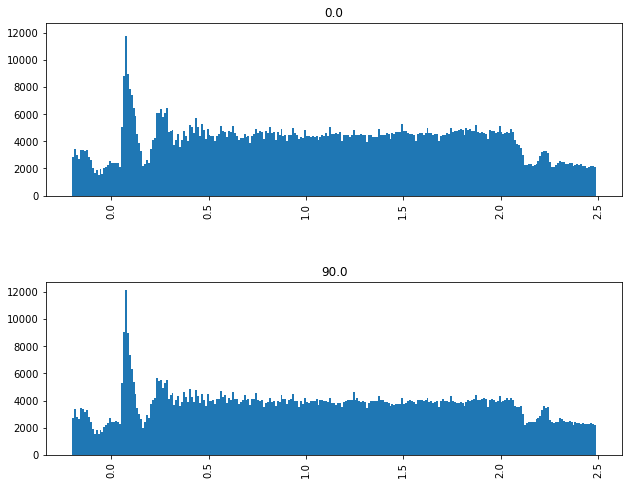

In [13]:
df.hist(column='time', 
        by='orientation', 
        bins=time_base, 
        sharey=True, 
        layout=(2, 1),
        figsize=[10, 8]
       )
plt.show()

Since we know there are 4 sort codes, we can also plot by both orientation and sort code. Here we turn off the `sharey` option, because the number of spikes varies by sort code. 

We pass a list of two columns to `by` in order to break the data down by both `oriantation` and `sort`, and then we specify the `layout` as 2 rows (orientation) and 4 columns (sort).

**Note:** This is actually not a valid thing to do from the point of view of the experiment, because the sort codes are unique to individual channels. That is, spike sorting is applied separately to each channel's data, so for example `sort_code==1` does not refer to the same neuron in channels 1 and 2. However, right now our main goal is to demonstrate how to compute and plot the PSTHs separately along two dimensions. Below we'll do that in a valid way, for all channels, but that's a lot (91), so let's start small.

In [ ]:
df.hist(column='time', 
        by=['orientation', 'sort'], 
        bins=time_base, 
        sharey=False, 
        layout=(2, 4),
        figsize=[15, 8]
       )
plt.show()

### Using `np.histogram()`

Although pandas provides the convenient `.histogram()` method, this is not the most flexible way to generate a plot. We can also compute histograms using `np.histogram()`, without immediately plotting them — just the way we did with the `ten_intensities` data. We save these histograms in memory, which allows more flexibility in how we later plot them. To do this, we have to loop over orientations and conditions, compute the histogram for each, and save these to plot later. 

Below we demonstrate two ways to do this, one using a dictionary to hold the results, and the other using list comprehension. They are equally fast, and either one is valid. However, an advantage of the dictionary approach is that we use keys to the dictionary that clearly indicate what combination of orientation and sort code each histogram is associated with. In contrast, when using list comprehension we have to generate a separate list of labels in parallel with the list containing the histograms (data) themselves. This is a bit less transparent — since unlike a dictionary, the labels aren't stored with the data. The list approach thus requires attention to detail to ensure that the list of labels is in the same order as the list of histograms. This also makes it more fragile and error-prone.

### The dictionary way

We generate a dictionary key for each combination of `sort` and `orientation`, and assign the histogram for each combination as the value for that key.

In [ ]:
psth_dict = {}

for ortn in orientations:
    for sort in sort_codes:
        label = str(ortn) + '_' + str(sort)
        psth_dict[label] = np.histogram(df[(df['orientation']==ortn) & 
                                           (df['sort']==sort)]['time'],
                                        bins=time_base
                                       )

In [ ]:
fig = plt.figure(figsize=[20,7])

# Loop through the keys of the PSTH dictionary
for i, label in enumerate(psth_dict.keys()):
    # set sublot based on number of orientations (rows) and number
    # of sort_codes (columns)
    ax = fig.add_subplot(num_ortns, len(sort_codes), i+1)
    
    # plot the histogram
    ax.plot(psth_dict[label][1][:-1], psth_dict[label][0])
    
    # Show when stimulus was on
    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')

    ax.set_title(label)
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
    plt.tight_layout() # helps ensure titles and label text don't overlap
    
plt.show()    

Note above the differences in total spike counts (*y* axis) between sort codes. This is beacuse every channel as at least a sort code of 1 (one neuron/unit), but fewer channels were found to contain data from 2 or more units. So decreasing amounts of data contribute to the averages for sort codes 1-4.

### The list comprehension way

Here we use nested list comprehension to create a list of the histograms. 

In [ ]:
psth_list = [np.histogram(df[(df['sort']==sort) & (df['orientation']==ortn)]['time'],
                          bins=time_base,
                         ) 
        for ortn in orientations
        for sort in sort_codes]

The histograms aren't labeled, so we need to make a second list containing the labels, using the same list comprehension (in the same order!) as we used above to create the list of histograms:

In [ ]:
psth_list_labels = [[ortn, sort] for ortn in orientations for sort in sort_codes]

Now we plot them, using essentially the same code as for the dictionary version. There are two differences: in how we loop through the histograms, and what we give `ax.plot()` as input.

In [ ]:
fig = plt.figure(figsize=[20,7])

for i in range(len(psth_list)):

    # set sublot based on number of orientations (rows) and number
    # of sort_codes (columns)
    ax = fig.add_subplot(num_ortns, len(sort_codes), i+1)

    # plot the histogram 
    ax.plot(psth_list[i][1][:-1], psth_list[i][0])

    # Show when stimulus was on
    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')

    ax.set_title(label)
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
    plt.tight_layout() # helps ensure titles and label text don't overlap
    

    
plt.show()    

### Overlaying Conditions

It's easier to make visual comparisons within a plot than between them. Since 0 and 90 degrees were the two experimental conditions that we'd want to compare, let's overlay them, keeping the separate panels for sort code. 

Note that this is a bit easier to do using the list method rather than the dictionary method, because in our list of labels, the orientation and sort code are two separate entries, so it's easy to pull out the orientations. Using the dictionary method, we'd need to parse the dictionary keys to pull out the orientation information.

In [ ]:
sort_codes

In [ ]:
fig = plt.figure(figsize=[20,5])

for i in sort_codes:
    ax = fig.add_subplot(1, len(sort_codes), int(i))
    zero = psth_list_labels.index([0., i])
    ax.plot(psth_list[zero][1][:-1], psth_list[zero][0])
    ninety = psth_list_labels.index([90., i])
    ax.plot(psth_list[ninety][1][:-1], psth_list[ninety][0], color='red')

    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    ax.set_title('Sort code ' + str(i))
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
    plt.tight_layout() 
    
plt.show()    

From this we can see that `sort_code 2.0` appears to be sensitive to orientation, as there is a difference in the probability of spiking, particularly between 1-2 s.

---
## PSTH for each channel

The above examples collapsed across all 96 channels in the microelectrode array. Let's now compute the PSTHs for each channel and orientation. 

In [ ]:
psth = [np.histogram(df[(df['orientation']==ortn) & (df['channel']==chan)]['time'],
                     bins=time_base
                    )
        for ortn in orientations
        for chan in channels]

# Generate the labels so we know what's what in the list above.
# Be sure to do the nested for loops in the same order (orientation then sort_code)
psth_labels = [[ortn, chan] for ortn in orientations for chan in channels]

To plot these, we use similar code to above. However, because there are 96 channels, we want to remove some axis labels from most plots (so it's less messy and less redundant). There's no way to make this not a huge image, since there are 96 panels to show, but by setting it to 4 columns we attain a good balance between readability and size.

In [ ]:
fig = plt.figure(figsize=[20, 40])

for i in channels:
    ax = fig.add_subplot(int(96/4), 4, int(i))
    zero = psth_labels.index([0., i])
    ax.plot(psth[zero][1][:-1], psth[zero][0], linewidth=.75)
    ninety = psth_labels.index([90., i])
    ax.plot(psth[ninety][1][:-1], psth[ninety][0], color='red', linewidth=.75)

    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')

    ax.set_title('Channel ' + str(i))

    if i== 1:
        ax.set_ylabel('Spike count per bin')
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    elif i == max(channels):
        ax.set_xlabel('Time(s)')
        ax.set_ylabel('')
        ax.set_yticklabels('')
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_ylabel('')
    
plt.show()    

One thing you'll note above is that there are some missing panels, including channels 21, 31, 34, 56, and 68. As noted above, these are the dead channels. The way the code above is written, we use the channel number as the index for the subplot position. Since there is no channel in the `channels` list for the dead channels, those subplot panels are simply left blank.

Beyond that, it's clear that different channels show very different response profiles. Some (e.g., 1, 2, 4, 5) show clear transient peaks in spiking activity soon after stimulus onset. Others do not. Some of the channels that show this initial peak return to baseline (low) levels of firing soon after, while others (e.g., 1, 20, 72) show a sustained plateau as long as the stimulus is on. Others (e.g., 3, 62) show no initial peak, but a steady rise in firing rate as the stimulus duration increases. As well, a few channels show orientation sensitivity, with clearly different responses between 0 (blue) and 90 (red) degree gratings (e.g., 29, 63, 75, 76, 91).

## Interactive plots

Plotting all 91 channels is a bit visually overwhelming. It's useful in appreciating the whole range of responses in different channels, but each plot is quite small. Here we use `ipywidgets` to generate an interactive plot, with a drop-down menu to select the channel we want to view.

**Note:** This will not display in the online book version, but it should work if you download and run this notebook file. To get this to work on your own system, you will need to at least run `jupyter labextension install @jupyter-widgets/jupyterlab-manager`, and possibly install additional pacakges if you don't have them already (although Anaconda seems to provide them).

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def psth_i(chan=channels):
    fig = plt.figure(figsize=[15,5]) 

    zero = psth_labels.index([0., chan])
    plt.plot(psth[zero][1][:-1], psth[zero][0], 
             linewidth=.75,
             label='0 deg'
            )
    ninety = psth_labels.index([90., chan])
    plt.plot(psth[ninety][1][:-1], psth[ninety][0], 
             color='red', 
             linewidth=.75,
             label='90 deg'
            )
    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    plt.legend()
    plt.title('Channel ' + str(int(chan)))
    plt.xlabel('Time (s)')
    plt.ylabel('Spike count per bin')

    plt.show()